In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

X_all = np.concatenate((X_train,X_test))

n = X_train.shape[0]


print(x_ray_features.shape)
print(X_train.shape, y_train.shape, X_train.dtype, np.sum(y_train==0), np.sum(y_train==1))
print(X_test.shape, y_test.shape, X_test.dtype, np.sum(y_test==0), np.sum(y_test==1))
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(13389, 1024)
(11389, 1024) (11389,) float32 6775 4614
(2000, 1024) (2000,) float32 1191 809


In [2]:
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull

legend_elements = [Line2D([0], [0], marker='.', lw=0, color='c', label='Normal'),
                   Line2D([0], [0], marker='.', lw=0, color='g', label='Pneumonia'),
                   #Line2D([0], [0], marker='.', lw=0, color='b', label='COVID-19'),
                   Line2D([0], [0], marker='*', lw=0, color='r', label='Normal (Test)'),
                   Line2D([0], [0], marker='*', lw=0, color='m', label='Pneumonia (Test)'),
                   #Line2D([0], [0], marker='*', lw=0, color='k', label='COVID-19 (Test)'),
                  ]


def plot_umap(y_umap, y_train, umap_test=None, y_test=None,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename=None, if_legend=False, loc='upper right'):
    
    colors = ['c', 'g', 'b', 'k']
    #markers = ['.', '+', '*', 'o']
    markers = ['.', '.', '.']
    markers_2 = ['.', '.', '.']
    colors_2 = ['r', 'm', 'k']

    #rot_angle = -55#np.pi - np.arctan(m2) #-60 for saved model, -50 for seed 100
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    mn = np.mean(y_umap, axis=0)

    Y = y_umap - mn
    Y = rot_mat.dot(Y.T).T
    
    hull = ConvexHull(Y)
    verts = hull.vertices
    verts = np.append( verts, hull.vertices[0] ) 
    
    

    markersize = 5

    plt.figure()
    #plt.title('UMAP - Non Parametric')

    for i in range(y_umap.shape[0]):
        plt.plot(x_neg*Y[i,0], y_neg*Y[i,1], 
                 color = colors[y_train[i]], 
                 marker = markers[y_train[i]],
                 markersize=markersize,alpha=0.1)
        
    plt.plot(x_neg*Y[verts,0], y_neg*Y[verts,1], 'k--', lw=2, alpha=0.5)
    
    if umap_test is not None:
        test_points = umap_test - mn
        test_points = rot_mat.dot(test_points.T).T
        
        for i in range(test_points.shape[0]):
            plt.plot(x_neg*test_points[i,0], y_neg*test_points[i,1], 
                    color = colors_2[y_test[i]], 
                    marker = markers_2[y_test[i]],#) #,
                    markersize=markersize)
    #plt.xticks([],[])
    #plt.yticks([],[])
    
    if if_legend:
        plt.legend(handles=legend_elements, loc=loc)
    
    plt.savefig('Pneumonia_FIGURES_30_Jan_2023/'+filename, bbox_inches='tight', dpi=400)
    return

In [3]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



<h1>K=15</h1>

None


/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


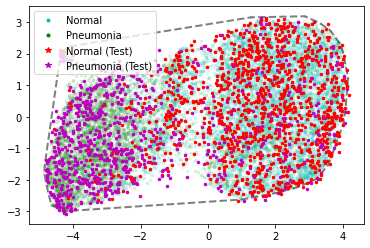

In [4]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = -10, x_neg = -1, y_neg = 1,
              filename='pneu_umap_k_15.png', if_legend=True, loc='upper left')

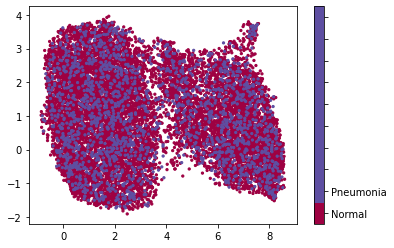

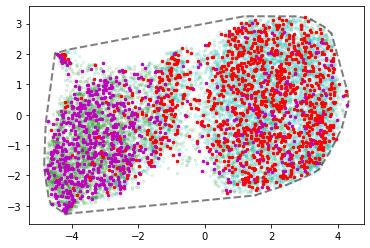

In [5]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_umap = t_umap_all[:X_train.shape[0]]
y_umap_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = -10, x_neg = -1, y_neg = 1,
              filename='pneu_umap_combined_k_15.png', if_legend=False)

<h1>K=30</h1>

None


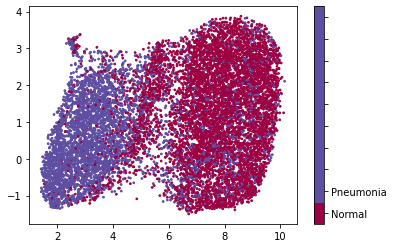

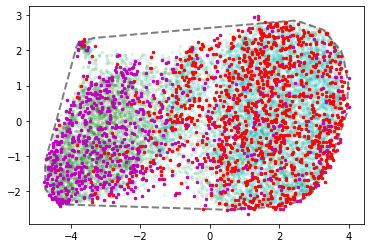

In [6]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_k_30.png', if_legend=False, loc='upper left')

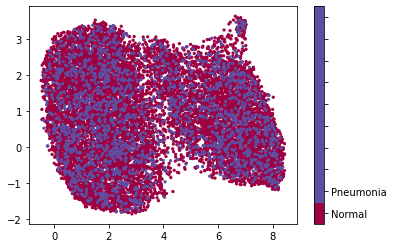

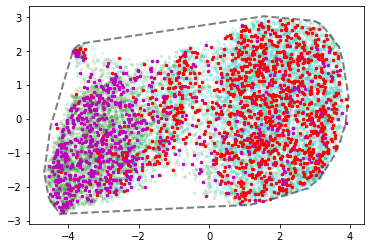

In [7]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_umap = t_umap_all[:X_train.shape[0]]
y_umap_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = -10, x_neg = -1, y_neg = 1,
              filename='pneu_umap_combined_k_30.png', if_legend=False)

<h1>k=50</h1>

None


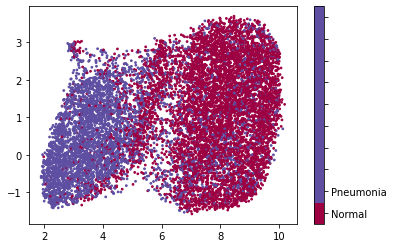

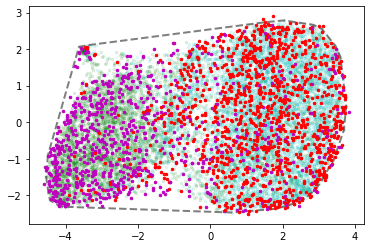

In [8]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=50,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_k_50.png', if_legend=False, loc='upper left')

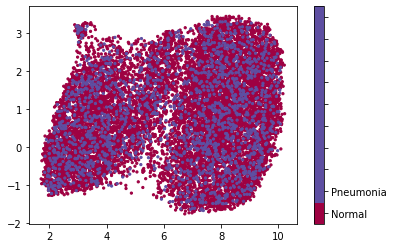

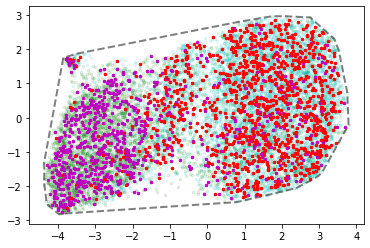

In [9]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=50,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_umap = t_umap_all[:X_train.shape[0]]
y_umap_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 10, x_neg = 1, y_neg = 1,
              filename='pneu_umap_combined_k_50.png', if_legend=False)